# データの準備

In [1]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [2]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [3]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [4]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [5]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

In [6]:
# # 「\n」を「」に置換する
# sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# # 「x000D」を「」に置換する
# sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# つぶやき分散表現

## モデル

In [7]:
# import torch
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # 使用するモデルを指定して、トークナイザとモデルを読み込む
# checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=Trueで分散表現を取得する

In [8]:
# from transformers import TRANSFORMERS_CACHE
# print(TRANSFORMERS_CACHE)

## 分散表現を取得

In [9]:
# from torch.utils.data import DataLoader


# # 入力文章をトークン化する関数
# def tokenize(text):
#     return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# # データローダーを作成する
# batch_size = 64
# dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

# # モデルをGPUに移動する
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # バッチ処理で分散表現を取得する
# embeddings = []
# with torch.no_grad():
#     for batch in dataloader:
#         # バッチをGPUに移動する
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         hidden_states = outputs.hidden_states
#         embeddings.append(hidden_states[-1][:, 0]) # 最後の層のCLSトークンのみ取得する

# embeddings = torch.cat(embeddings)

# # in 1min


In [10]:
# # pandasのDataFrameに変換する
# df_embeddings = pd.DataFrame(embeddings.tolist())

# df_embeddings.info()

In [11]:
# # 保存する
# df_embeddings.to_csv('embeddings/pretrained_embeddings.tsv', sep='\t', index=False, header=False)

In [12]:
# 読み込み
df_embeddings = pd.read_table('embeddings/pretrained_embeddings.tsv', header=None)
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.138063,-0.084938,-0.255143,-0.183175,-0.358470,-0.072585,0.040222,-0.286359,0.045356,-0.319359,...,0.032409,-0.160296,0.301594,-0.178500,0.123455,-0.595417,0.032109,-0.170379,0.164140,-0.315099
1,-0.052320,-0.088336,-0.272925,-0.057316,-0.315290,-0.143158,0.077195,-0.157071,0.072004,-0.361723,...,0.061560,-0.215631,0.250838,-0.160428,0.098604,-0.510323,0.202751,-0.102272,0.153054,-0.095640
2,-0.177626,-0.262159,-0.003788,-0.160909,-0.340622,-0.001606,0.122331,-0.233459,0.119325,-0.608892,...,-0.098919,0.035432,0.416226,-0.186572,0.187101,-0.569462,0.095761,-0.104089,0.105838,-0.043242
3,-0.397890,-0.091548,-0.226174,-0.293630,-0.380104,-0.037533,-0.125908,-0.183021,0.064090,-0.046717,...,-0.121586,0.193287,0.107693,-0.048663,-0.019154,-0.337971,0.065568,-0.072375,-0.264562,0.103062
4,0.032386,-0.021481,0.295753,-0.115124,-0.239984,0.167848,0.077507,0.163796,0.062094,-0.520862,...,-0.007872,-0.000184,0.420004,0.030601,0.157687,-0.397507,0.224163,-0.213541,-0.028670,0.103872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,-0.216995,-0.016561,-0.168879,-0.227172,-0.020628,0.096183,0.068294,-0.065994,0.050766,-0.190435,...,-0.030952,0.192423,0.173386,-0.030220,0.121093,-0.702992,-0.075431,-0.390060,-0.400430,0.082526
18233,-0.291239,-0.266846,-0.168791,-0.165805,-0.121912,0.049772,0.092832,-0.113600,0.058416,-0.260933,...,-0.078520,0.091790,0.176077,-0.010619,0.140708,-0.605239,-0.144969,-0.020877,-0.392496,0.068692
18234,-0.085115,-0.343193,0.025743,-0.128169,-0.182736,0.256788,0.004219,-0.174991,0.168885,-0.154515,...,-0.070025,-0.177166,0.266739,0.064553,-0.180521,-0.354609,-0.074309,-0.093084,-0.184356,0.020734
18235,-0.291150,-0.223811,-0.108272,-0.166970,-0.216084,0.036603,0.168181,-0.244096,0.084860,-0.251601,...,0.123334,-0.095719,0.459118,-0.051616,-0.071088,-0.653548,0.042143,-0.188449,-0.255342,-0.125009


### 文章間の類似度

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 1

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 1
文　章：今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
類似度：1.0
---
index: 9482
文　章：今日はあったかいね。電車待ちのベンチで、日差しが眩しいくらいだ。空も澄み渡っている。いつもこんな気持ちでいられたら幸せだなぁ
類似度：0.9566031265380633
---
index: 14243
文　章：ガラクタイチ行きたい?。東寺は去年八月以来だなぁ。あの暗がりのベンチに座ってヒトを眺めたい水族館。住みたいくらいすきよキョート。
類似度：0.9545356681951824
---
index: 5238
文　章：この街にはベンチが無いのでどこで黄昏れるべきかわからない。夕方はとてもねむい。
類似度：0.9519550738857954
---
index: 11783
文　章：ウワァーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
類似度：0.3812982699604953
---
index: 6896
文　章：アアアアアアアアアアアアアアアアアアアアアアアアアアアアアアアアアアイラアアアアアアアアアアアアアア
類似度：0.4113523182702361
---
index: 13767
文　章：台風（；＿；）（；＿；）（；＿；）
類似度：0.4302533684536746
---


---

# クラスタリング

In [14]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_
# clustersに1を足すことで、クラスター番号を1から始める
clusters = clusters + 1

c:\Users\yossh\anaconda3\envs\bert_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


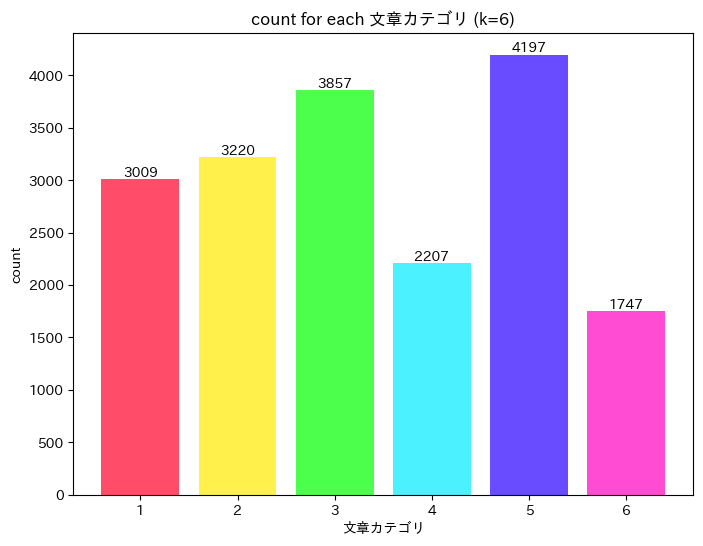

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('count')
plt.title(f'count for each 文章カテゴリ (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

In [16]:
k_max=40

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [17]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

<img src="figures/pretrained_elbow.png">

### シルエット係数による最適クラスター数の調査

In [18]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)\n    silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

<img src = "figures/pretrained_silhouette.png">

### シルエット図

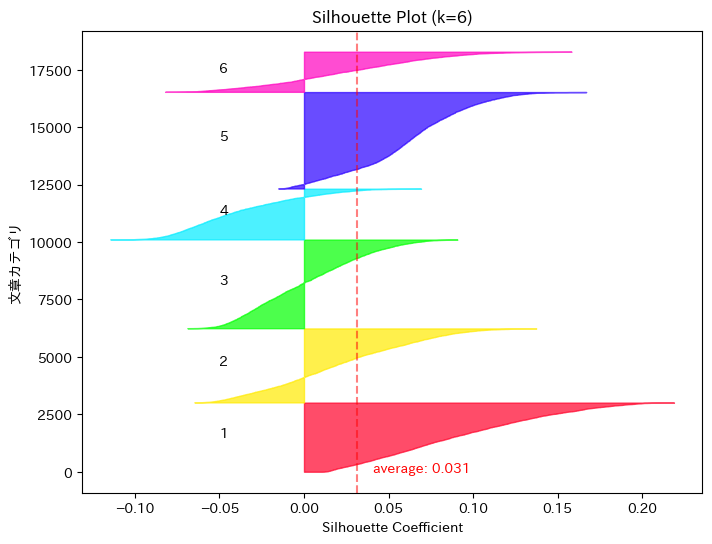

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [20]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 1
シルエット係数が最も高い文章: この夏、めまいがひどくて病院行ったらストレスが原因だと大量に薬を処方され、ストレスをなくしましょう、気分転換にホットヨガがいいですよとか言われたが、今の生活習慣でこうなってるんだから、習慣を変えない限りは好転しないんだろと思いつつ、ホットヨガ分の時間とお金を捻出する気力もない。
シルエット係数: 0.219
---
文章カテゴリ: 2
シルエット係数が最も高い文章: マナちゃんきたね！
シルエット係数: 0.137
---
文章カテゴリ: 3
シルエット係数が最も高い文章: 暴食は自己肯定感が下がる。
シルエット係数: 0.091
---
文章カテゴリ: 4
シルエット係数が最も高い文章: 悲しい 
シルエット係数: 0.069
---
文章カテゴリ: 5
シルエット係数が最も高い文章: 正直買い物行くくらいでディスポ使いたくないんよなもう 
シルエット係数: 0.167
---
文章カテゴリ: 6
シルエット係数が最も高い文章: もう夏なのに、コロナの勢い衰えないな(・・;)\n\n冬が心配だぜ(_ _;)
シルエット係数: 0.158
---


In [21]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 5
シルエット係数が高い文章: 正直買い物行くくらいでディスポ使いたくないんよなもう 
シルエット係数: 0.167
---
文章カテゴリ: 5
シルエット係数が高い文章: こんな感じだと次の仕事考えちゃうわ
シルエット係数: 0.163
---
文章カテゴリ: 5
シルエット係数が高い文章: ってネトフリでやってたじゃん！
シルエット係数: 0.157
---
文章カテゴリ: 5
シルエット係数が高い文章: なんか事故ってタバスコ目に入ったっぽいけど、これホントやばいw
シルエット係数: 0.156
---
文章カテゴリ: 5
シルエット係数が高い文章: 久しぶりに俺やればできるじゃんって思えた
シルエット係数: 0.156
---


## クラスタリング結果の可視化

### PCA

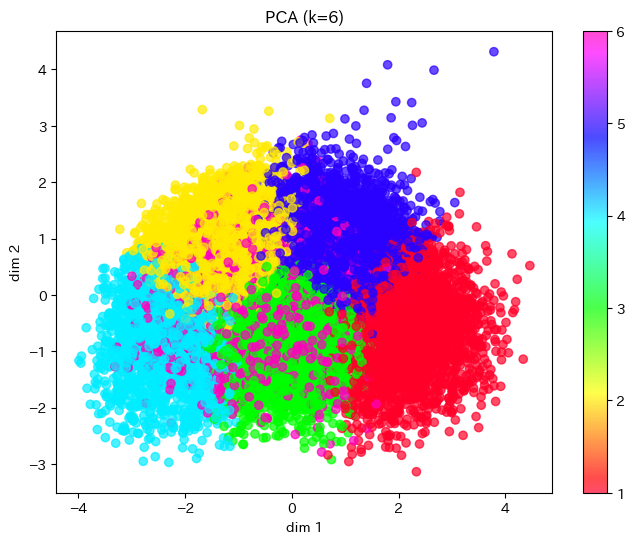

In [22]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCA (k={k})')
plt.colorbar()
plt.show()

### t-SNE

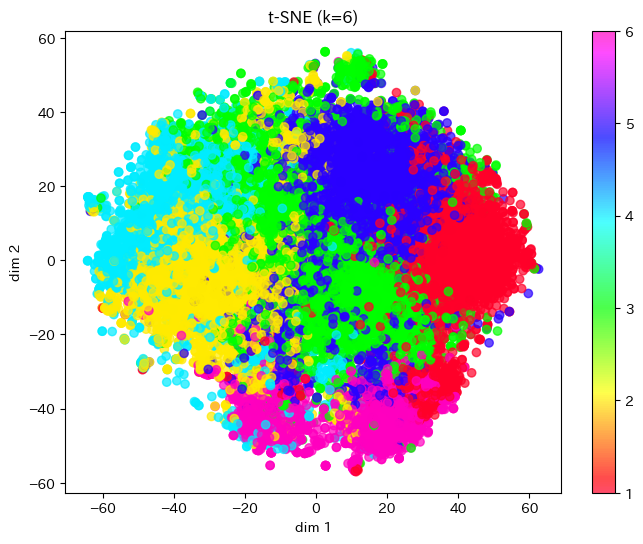

In [23]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [24]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAP (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAP (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [25]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [26]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


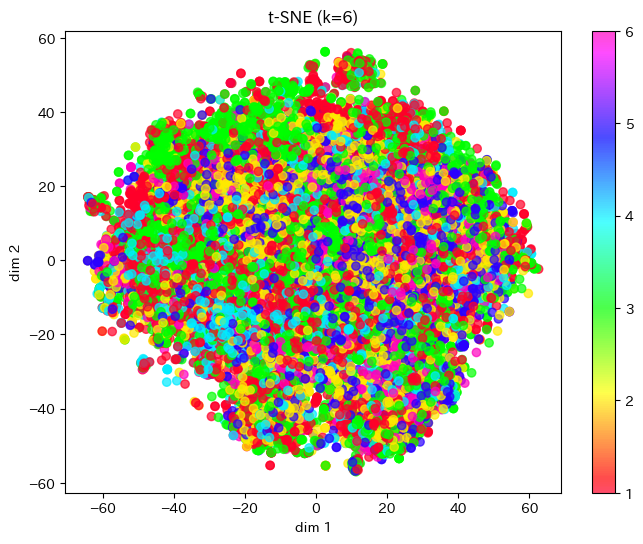

In [27]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [28]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.138063,-0.084938,-0.255143,-0.183175,-0.358470,-0.072585,0.040222,-0.286359,0.045356,...,-0.160296,0.301594,-0.178500,0.123455,-0.595417,0.032109,-0.170379,0.164140,-0.315099,1
1,train,-0.052320,-0.088336,-0.272925,-0.057316,-0.315290,-0.143158,0.077195,-0.157071,0.072004,...,-0.215631,0.250838,-0.160428,0.098604,-0.510323,0.202751,-0.102272,0.153054,-0.095640,3
2,train,-0.177626,-0.262159,-0.003788,-0.160909,-0.340622,-0.001606,0.122331,-0.233459,0.119325,...,0.035432,0.416226,-0.186572,0.187101,-0.569462,0.095761,-0.104089,0.105838,-0.043242,0
3,train,-0.397890,-0.091548,-0.226174,-0.293630,-0.380104,-0.037533,-0.125908,-0.183021,0.064090,...,0.193287,0.107693,-0.048663,-0.019154,-0.337971,0.065568,-0.072375,-0.264562,0.103062,2
4,train,0.032386,-0.021481,0.295753,-0.115124,-0.239984,0.167848,0.077507,0.163796,0.062094,...,-0.000184,0.420004,0.030601,0.157687,-0.397507,0.224163,-0.213541,-0.028670,0.103872,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.216995,-0.016561,-0.168879,-0.227172,-0.020628,0.096183,0.068294,-0.065994,0.050766,...,0.192423,0.173386,-0.030220,0.121093,-0.702992,-0.075431,-0.390060,-0.400430,0.082526,0
18233,train,-0.291239,-0.266846,-0.168791,-0.165805,-0.121912,0.049772,0.092832,-0.113600,0.058416,...,0.091790,0.176077,-0.010619,0.140708,-0.605239,-0.144969,-0.020877,-0.392496,0.068692,2
18234,train,-0.085115,-0.343193,0.025743,-0.128169,-0.182736,0.256788,0.004219,-0.174991,0.168885,...,-0.177166,0.266739,0.064553,-0.180521,-0.354609,-0.074309,-0.093084,-0.184356,0.020734,0
18235,train,-0.291150,-0.223811,-0.108272,-0.166970,-0.216084,0.036603,0.168181,-0.244096,0.084860,...,-0.095719,0.459118,-0.051616,-0.071088,-0.653548,0.042143,-0.188449,-0.255342,-0.125009,2


In [29]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [30]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.71373	test-mlogloss:1.68914
[1]	train-mlogloss:1.66550	test-mlogloss:1.62392
[2]	train-mlogloss:1.63155	test-mlogloss:1.57341
[3]	train-mlogloss:1.60491	test-mlogloss:1.54060
[4]	train-mlogloss:1.58257	test-mlogloss:1.51162
[5]	train-mlogloss:1.56380	test-mlogloss:1.49211
[6]	train-mlogloss:1.54752	test-mlogloss:1.47159
[7]	train-mlogloss:1.53256	test-mlogloss:1.45623
[8]	train-mlogloss:1.51855	test-mlogloss:1.43817
[9]	train-mlogloss:1.50585	test-mlogloss:1.42580
[10]	train-mlogloss:1.49404	test-mlogloss:1.41228
[11]	train-mlogloss:1.48285	test-mlogloss:1.40261
[12]	train-mlogloss:1.47224	test-mlogloss:1.39502
[13]	train-mlogloss:1.46217	test-mlogloss:1.38551
[14]	train-mlogloss:1.45251	test-mlogloss:1.37747
[15]	train-mlogloss:1.44328	test-mlogloss:1.36979
[16]	train-mlogloss:1.43428	test-mlogloss:1.36126
[17]	train-mlogloss:1.42595	test-mlogloss:1.35350
[18]	train-mlogloss:1.41795	test-mlogloss:1.34469
[19]	train-mlogloss:1.41019	test-mlogloss:1.33619
[20]	train

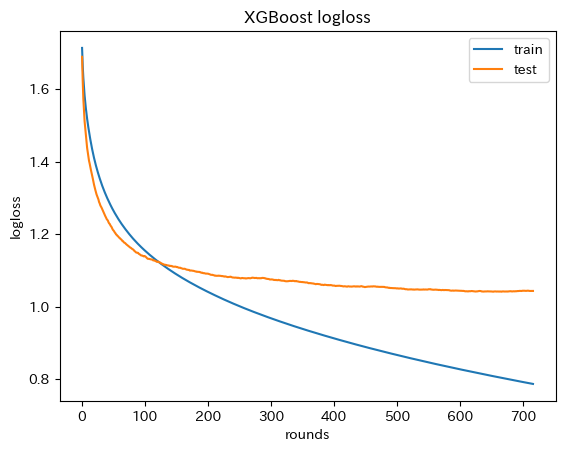

In [31]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [32]:
test_labels += 1
preds_labels += 1

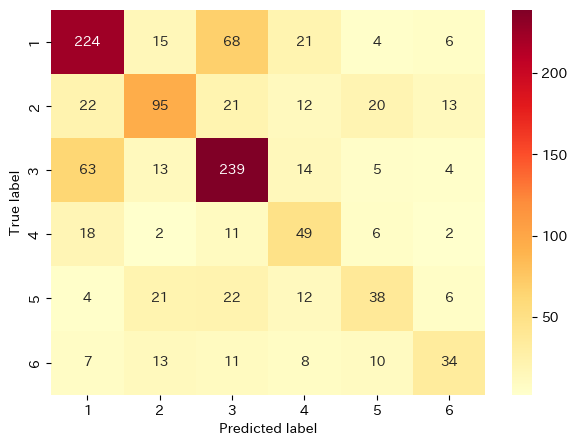

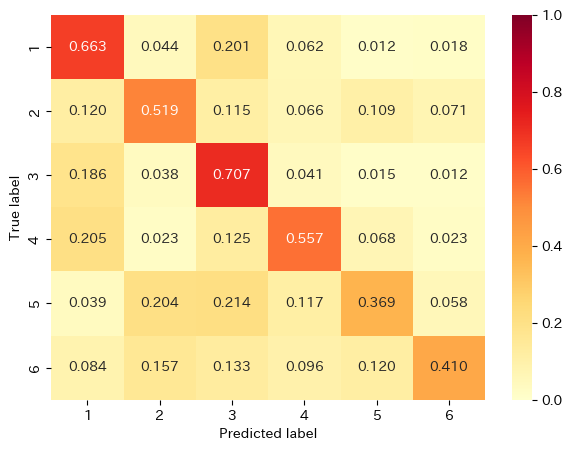

              precision    recall  f1-score   support

           1      0.663     0.663     0.663       338
           2      0.597     0.519     0.556       183
           3      0.642     0.707     0.673       338
           4      0.422     0.557     0.480        88
           5      0.458     0.369     0.409       103
           6      0.523     0.410     0.459        83

    accuracy                          0.599      1133
   macro avg      0.551     0.537     0.540      1133
weighted avg      0.599     0.599     0.596      1133



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [34]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

この性格の悪さを何とかしたい…
True label: 2
Predicted label: 1.0
---
職場でお寿司連れてってもらってお腹パンパン！デザートまで出してもらって大満足。苦しくなるほど食べられるなんて幸せじゃないか。
True label: 3
Predicted label: 1.0
---
友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 1
Predicted label: 3.0
---
ホットカーペットに寝っ転がってうとうとするのサイコー。
True label: 5
Predicted label: 2.0
---
ん？ONE PIECEの歌がなんかヘン。
True label: 3
Predicted label: 5.0
---


---

### pretrained bertのクラスタリングと感情カテゴリーの一致度

In [35]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])

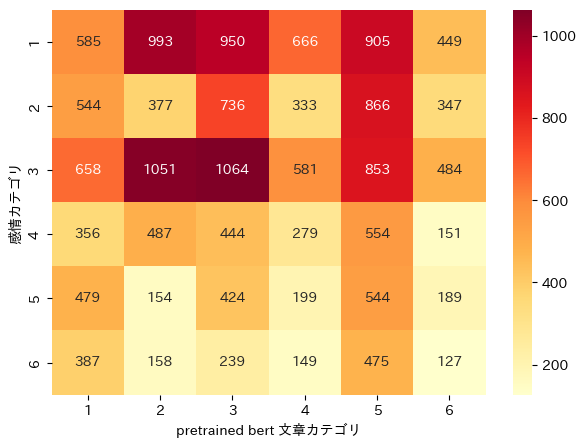

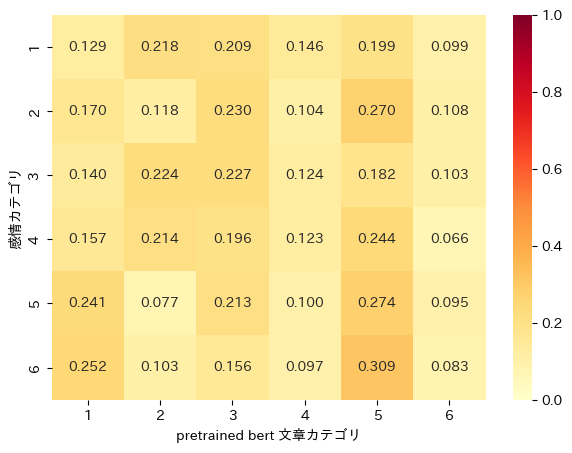

In [36]:

# pretrained bertのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_emotion_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()